In [1]:
import sys
from pathlib import Path

def find_repo_root(start: Path) -> Path:
    start = start.resolve()
    for p in [start, *start.parents]:
        if (p / "geoseg").is_dir() and (p / "config").is_dir():
            return p
    raise FileNotFoundError(f"Could not find repo root from {start}")

repo_root = find_repo_root(Path.cwd())
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

SPLIT_ROOT = repo_root / "data" / "biodiversity_split" / "train_rep"  # Stage-3 weights are computed on train_rep
MSK_DIR = SPLIT_ROOT / "masks"
WEIGHTS_TXT = repo_root / "artifacts" / "sample_weights.txt"

OUT_DIR = repo_root / "figures"
OUT_DIR.mkdir(parents=True, exist_ok=True)
OUT_PDF = OUT_DIR / "fig8_hard_sampling_schematic.pdf"

print("Repo root:", repo_root)
print("Masks dir:", MSK_DIR)
print("Weights:", WEIGHTS_TXT)
print("Output:", OUT_PDF)

assert MSK_DIR.exists(), f"Missing masks dir: {MSK_DIR}"
assert WEIGHTS_TXT.exists(), f"Missing weights file: {WEIGHTS_TXT} (run scripts/analyze_hard_samples.py first)"


Repo root: /home/lainey/Documents/Github/ClassImbalance
Masks dir: /home/lainey/Documents/Github/ClassImbalance/data/biodiversity_split/train_rep/masks
Weights: /home/lainey/Documents/Github/ClassImbalance/artifacts/sample_weights.txt
Output: /home/lainey/Documents/Github/ClassImbalance/figures/fig8_hard_sampling_schematic.pdf


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from PIL import Image
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap, BoundaryNorm

mpl.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman", "Times", "DejaVu Serif"],
    "mathtext.fontset": "stix",
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10,
})


In [6]:
# --- palette + class names ---
COLOR_MAP = {
    0: [0, 0, 0],
    1: [250, 62, 119],
    2: [168, 232, 84],
    3: [242, 180, 92],
    4: [59, 141, 247],
    5: [255, 214, 33],
}

CLASS_NAMES = [
    "Background", "Forest land", "Grassland", "Cropland",
    "Settlement", "Semi-natural grassland"
]

colors = np.array([np.array(COLOR_MAP[i]) / 255.0 for i in range(6)])
cmap = ListedColormap(colors)
norm = BoundaryNorm(np.arange(-0.5, 6.5), cmap.N)


In [7]:
def load_weights_table(weights_txt: Path):
    img_ids = []
    wts = []
    with open(weights_txt, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            img_id, w = line.split("\t")
            img_ids.append(img_id)
            wts.append(float(w))
    wts = np.array(wts, dtype=np.float32)
    return img_ids, wts

img_ids, wts = load_weights_table(WEIGHTS_TXT)
print("Loaded weights:", len(wts), "min/med/max:", float(wts.min()), float(np.median(wts)), float(wts.max()))

# pick representative "easy" and "hard" examples
q_lo, q_hi = 0.10, 0.90
w_lo = np.quantile(wts, q_lo)
w_hi = np.quantile(wts, q_hi)

idx_easy = int(np.argmin(np.abs(wts - w_lo)))
idx_hard = int(np.argmin(np.abs(wts - w_hi)))

easy_id, easy_w = img_ids[idx_easy], float(wts[idx_easy])
hard_id, hard_w = img_ids[idx_hard], float(wts[idx_hard])

print("Easy:", easy_id, "weight:", easy_w)
print("Hard:", hard_id, "weight:", hard_w)


Loaded weights: 2646 min/med/max: 1.0 1.3476240634918213 5.0
Easy: biodiversity_0660 weight: 1.1411679983139038
Hard: biodiversity_1939 weight: 1.9966089725494385


In [8]:
def mask_path_from_id(msk_dir: Path, img_id: str) -> Path:
    # img_id in your pipeline is a stem like "biodiversity_0014"
    p = msk_dir / f"{img_id}.png"
    if not p.exists():
        # fallback: try direct glob if naming differs
        hits = list(msk_dir.glob(f"{img_id}*.png"))
        if hits:
            return hits[0]
        raise FileNotFoundError(f"Mask not found for {img_id}: {p}")
    return p

easy_mask_path = mask_path_from_id(MSK_DIR, easy_id)
hard_mask_path = mask_path_from_id(MSK_DIR, hard_id)

easy_mask = np.array(Image.open(easy_mask_path))
hard_mask = np.array(Image.open(hard_mask_path))

print("Easy mask:", easy_mask_path.name, easy_mask.shape, easy_mask.dtype)
print("Hard mask:", hard_mask_path.name, hard_mask.shape, hard_mask.dtype)


Easy mask: biodiversity_0660.png (512, 512) uint8
Hard mask: biodiversity_1939.png (512, 512) uint8


In [9]:
def add_panel_label_above_center(ax, label, fontsize=12):
    ax.text(
        0.5, 1.02, label,
        transform=ax.transAxes,
        ha="center", va="bottom",
        fontsize=fontsize, fontweight="bold"
    )


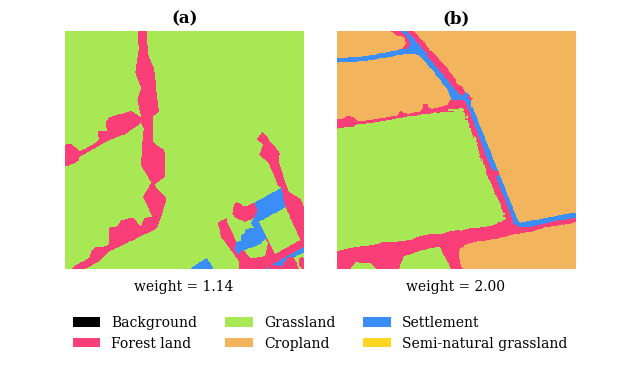

Saved: /home/lainey/Documents/Github/ClassImbalance/figures/fig8_hard_sampling_schematic.pdf


In [17]:
def plot_fig8_hard_sampling(easy_mask, hard_mask, easy_w, hard_w, out_pdf: Path):
    fig = plt.figure(figsize=(8, 4.2))
    gs = fig.add_gridspec(2, 2, height_ratios=[1, 0.18], hspace=0.30, wspace=-0.22)

    # (a) easy
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.imshow(easy_mask, cmap=cmap, norm=norm, interpolation="nearest")
    ax1.set_axis_off()
    add_panel_label_above_center(ax1, "(a)")
    # optional tiny weight annotation (comment out if you want nothing on-panel)
    ax1.text(0.5, -0.04, f"weight = {easy_w:.2f}", transform=ax1.transAxes,
             ha="center", va="top", fontsize=10)

    # (b) hard
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.imshow(hard_mask, cmap=cmap, norm=norm, interpolation="nearest")
    ax2.set_axis_off()
    add_panel_label_above_center(ax2, "(b)")
    ax2.text(0.5, -0.04, f"weight = {hard_w:.2f}", transform=ax2.transAxes,
             ha="center", va="top", fontsize=10)

    # legend row
    legend_ax = fig.add_subplot(gs[1, :])
    legend_ax.axis("off")
    handles = [Patch(facecolor=colors[i], label=CLASS_NAMES[i]) for i in range(6)]
    legend_ax.legend(handles=handles, loc="center", ncol=3, frameon=False, fontsize=10)

    out_pdf.parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(out_pdf, bbox_inches="tight")
    plt.show()
    plt.close(fig)

    print("Saved:", out_pdf)

plot_fig8_hard_sampling(easy_mask, hard_mask, easy_w, hard_w, OUT_PDF)


In [11]:
idx_min = int(np.argmin(wts))
idx_max = int(np.argmax(wts))
print("Min:", img_ids[idx_min], float(wts[idx_min]))
print("Max:", img_ids[idx_max], float(wts[idx_max]))


Min: den0_0022 1.0
Max: den4_0009 5.0
